# Astro 505 assignment 2
Brittany Howard

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import *
from astropy.cosmology import WMAP7 as cosmo # flat, wmap7 parameters
from scipy.integrate import quad

%matplotlib inline

# Question 1
* Compute and plot the luminosity distance and differential co-moving volume as a function of redshift over the interval $0 < z < 2$. You may assume that the Universe is described by a spatially flat Friedmann-Robertson-Walker model defined by the WMAP 7 cosmological parameters.


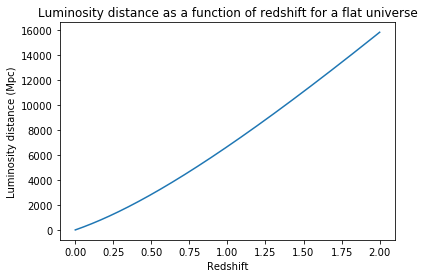

In [2]:
# define redshift range
z = np.arange(.001, 2.001, .001)

# get the luminosity distance
lum_dist = (cosmo.luminosity_distance(z)).value

# plot
plt.plot(z, lum_dist)
plt.title('Luminosity distance as a function of redshift for a flat universe')
plt.xlabel('Redshift')
plt.ylabel('Luminosity distance (Mpc)')

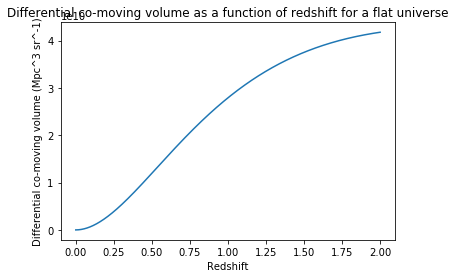

In [3]:
# Now I'll do the same for differential co-moving volume
diff_co_vol = (cosmo.differential_comoving_volume(z)).value

plt.plot(z, diff_co_vol)
plt.title('Differential co-moving volume as a function of redshift for a flat universe')
plt.xlabel('Redshift')
plt.ylabel('Differential co-moving volume (Mpc^3 sr^-1)')

* The CFHT Legacy Survey Deep component is a 4 deg$^2$ imaging survey complete to $r = 27.6$. Using the basic LF parameters from your notes (assume that they describe the r-band), at what redshift does a M∗ galaxy display an apparent magnitude equal to the survey magnitude limit? You may assume that the k-correction is dominated by the bandwidth term and that the rest-frame galaxy SEDs evolve to become brighter with increasing redshift according to $E(z) = M(z) − M(z = 0) = −0.75 × z$ for $z < 1$ and constant thereafter (i.e. $E(z) = −0.75$).

Note: this needs to be done by considering redshift "shells"; at higher redshift, we see fewer sufficiently bright glaxies, but the volume is larger, so there are more galaxies in total. So there should be a peack in number of galaxies that we can see at a given redshift somewhere.

So, we need to get apparent magnitude $m_r$ of an M * galaxy as a function of redshift, and then find the redshift at which the apparent magnitude $m_r = 27.6$.

We have a expression for doing this given in the notes section 1.5:

$M_r = m_r - 25 - 5\log d_L(z) -K_r(z) + A_r$.

Rearranging to isolate $m_r$ gives

$m_r = M_r + 25 + 5\log d_L(z) + K_r(z) - A_r$.

$M_r$ is the absolute magnitude; $M^*$ is a characteristic magnitude, perhaps this is it? Better read about this. In the notes, it's given as -20.6.

We know the we can neglect the second term of the k-correction, so we have $K_r(z) = 2.5\log(1+z)$.

We can get luminiosity distance as a function of redshift with astropy, so now the only missing piece is the galactic extinction term. I'm pretty sure that this is what's given in the problem as $E(z)$.

Putting it all together, we have a piecewise function. For $z<1$, we get

$m_r = M^* + 25 + 5\log d_L(z) + 2.5\log(1+z) + 0.75z$, 

and for $z \geq 1$, 

$m_r = M^* + 25 + 5\log d_L(z) + 2.5\log(1+z) + 0.75$

This is the solution, but I'll make a plot so that I can visualize it:


In [4]:
def app_magn(z, M_star):
    if z < 1: 
        app_magn = M_star + 25 + 5*np.log10((cosmo.luminosity_distance(z)).value) + 0.75 * z
    else:
        app_magn = M_star + 25 + 5*np.log10((cosmo.luminosity_distance(z)).value) + 0.75
    return app_magn

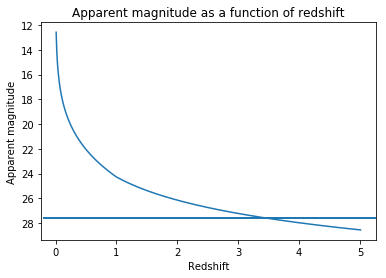

In [5]:
# calculate 
z = np.arange(.01, 5.02, 0.01)
app_magnitude = np.array([])

for redshift in z:
    app_magnitude = np.append(app_magnitude, app_magn(redshift, -20.6))

# plot
plt.plot(z, app_magnitude)
plt.axhline(y=27.6, xmin=0.01, xmax=5.02, linewidth=2)
plt.title('Apparent magnitude as a function of redshift')
plt.xlabel('Redshift')
plt.ylabel('Apparent magnitude')
plt.gca().invert_yaxis()

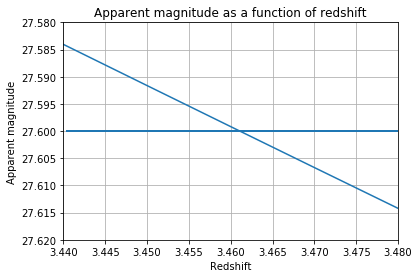

In [6]:
# I'll do it again, zoomed in this time
plt.plot(z, app_magnitude)
plt.axhline(y=27.6, xmin=0.01, xmax=5.02, linewidth=2)
plt.title('Apparent magnitude as a function of redshift')
plt.xlabel('Redshift')
plt.ylabel('Apparent magnitude')
plt.xlim(3.44,3.48)
plt.ylim(27.58,27.62)
plt.gca().invert_yaxis()
plt.grid()

Okay, so it appears that this occurs very close to redshift $z=3.461$.

* What volume is contained within this redshift? 

This is the co-moving volume.

In [7]:
vol_contained = cosmo.comoving_volume(z=3.461)
print(vol_contained)

1392365813544.3823 Mpc3


* Using the local LF parameters and the above assumptions regarding the k-correction and evolutionary terms, how many galaxies would you expect to be observed in an r < 27.6 selected catalogue based upon CFHTLS Deep observations?

To do this, I'll take the galaxy density function (Eq. 8) from the Lin paper and evaluate it within one tiny redshift shell at a time. For each shell, I will multiply by the volume of that shell. And then I will add up all of those individual contributions to get the total number. 

Note that we can solve for the apparent magnitude limit in each shell because we know that value of the distance modulus now.

Actually, I have a simpler plan. I can simply integrate for the luminosity and the luminosity density, both as functions of z, and then multiply them to get the total expected number of galaxies.

From the notes:
* $\phi∗ = 5.5 × 10^{−3}$gals Mpc$^{−3}$
* $L^∗ =2×1010$L$_⊙$ or $M^∗ =−20.6$
* $\alpha=-1.2$

In [10]:
# we know M_star, phi_star, alpha from the notes
def magnitude_density(M, phi_star=5.5*10**-3, M_star=-20.6, alpha=-1.2):  # Lin eq 8
    phi = (0.4 * np.log(10)) * phi_star * (10**(0.4*(M_star-M)))**(1.+alpha) * np.exp((-10**(0.4*(M_star-M))))
    return(phi)

def get_M_lim(z):
    M_lim = 27.6 - 25 - 5 * np.log10(cosmo.luminosity_distance(z).value) - k(z)
    return(M_lim)

def k(z):   # actually k(z) + E(z)
    if z < 1.:
        k = 2.5 * np.log10(1 + z) + 0.75 * z
    else:
        k = 2.5 * np.log10(1 + z) + 0.75
    return(k)

For getting `M_lim`, we know that the distance modulus is given by $M-m = -25 - 5\log{d_L(z)} - k(z)$. We know that $m$ will always be 27.6, so we can isolate $M$.

In [11]:
# break the space up into redshift shells
num_shells = 1000
dz = 3.46/num_shells
redshift = np.arange(dz, 3.46, dz)
total_num_galaxies = 0  # increase this later

for z in redshift:  # loop through redshift shells
    # find the limit for the lowest possible absolute magnitude at this redshift:
    M_lim = get_M_lim(z)
    
    mag_density = quad(func=magnitude_density, a=-100, b=M_lim)[0]  # can't use -oo for the lower limit, the integral breaks

    # calculate volume of shell
    shell_volume = 4./41253. *  (cosmo.comoving_volume(z).value - cosmo.comoving_volume(z-dz).value)
    
    # number of galaxies expected in this shells
    num_galaxies = mag_density * shell_volume

    # add this number to our total
    total_num_galaxies += num_galaxies    
    

print('Total expected number of galaxies within the catalog : {}'.format(total_num_galaxies))

Total expected number of galaxies within the catalog : 701800.0309843376


## Question 2
Compute the galaxy luminosity function for the Las Campanas Redshift Survey (LCRS). The LCRS consists of a sample of 18,678 galaxies with measured r–band apparent magnitudes and spectroscopic redshifts. Catalogue information for the LCRS may be obtained at the following URL:
     https://heasarc.gsfc.nasa.gov/w3browse/all/lcrscat.html
The LCRS LF analysis is described in Lin et al. 1996, ApJ, 464, 60.

* Retrieve the field and catalogue data and the paper. Note that, although the catalogue contains some 80,000 entries, we are only interested in those with redshift information.

In [12]:
# read in LCRS data
catalog = fits.getdata('catalog.fits')
catalog.columns

ColDefs(
    name = 'FIELD_NAME'; format = 'A10'; start = 1
    name = 'NAME'; format = 'A21'; start = 12
    name = 'ISOPHOTAL_MAG'; format = 'F13.0'; unit = 'MAG'; disp = 'F13.2'; start = 34
    name = 'RADIAL_VELOCITY'; format = 'I15'; unit = 'KM/S'; start = 48
    name = 'RADIAL_VELOCITY_ERROR'; format = 'I21'; unit = 'KM/S'; start = 64
    name = 'CLASS'; format = 'A6'; start = 86
)

In [13]:
# have to solve for redshift, z = v/c
redshift = catalog['RADIAL_VELOCITY'] / (2.998 * 10 ** 5 ) # radial velocity in km/s

catalog = Table(catalog)
new_col = Column(redshift, name='REDSHIFT')
catalog.add_column(new_col)

In [14]:
catalog

FIELD_NAME,NAME,ISOPHOTAL_MAG,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,CLASS,REDSHIFT
str10,str21,float64,int32,int32,str7,float64
0015-42M,LCRS B002517.7-421621,17.48,45629,56,GALAXY,0.152198132088
2255-42M,LCRS B231051.9-421601,16.12,1679,33,GALAXY,0.00560040026684
0400-42W,LCRS B040221.3-420748,17.36,63898,73,GALAXY,0.213135423616
2215-42W,LCRS B222214.5-421454,17.0,16210,56,GALAXY,0.0540693795864
2135-42W,LCRS B214037.7-421325,16.21,21454,40,GALAXY,0.0715610406938
0054-42M,LCRS B010511.2-421539,17.74,53196,56,GALAXY,0.177438292195
0134-42W,LCRS B014055.9-421443,16.6,28587,47,GALAXY,0.095353569046
0015-42W,LCRS B002338.6-421614,17.24,45735,57,GALAXY,0.152551701134
0415-42W,LCRS B041730.1-420647,17.12,15876,38,GALAXY,0.0529553035357


* Use the FRW WMAP 7 cosmological model described earlier.

Okay, no need to do anything here.

* Compute the galaxy luminosity function:

* Equations (1), (2), and (3) of the Lin et al. paper make several assumptions regarding the treatment of cosmological effects. Question each assumption as follows:

* i. Equation (1) assumes that the effects of passive stellar evolution within the sample are small. What is the computed look–back time between a redshift z = 0 and the median redshift of the sample (z = 0.1)? Would you expect passive stellar evolution to be much of an effect here? Justify your answer with reference to the typical main sequence turn off ages of different stellar types or with reference to any relevant literature on the expected amplitude of stellar evolution. Assume that a typical star in a typical LCRS galaxy is 6 Gyr old.

Okay, so first let's calculate the lookback time:

In [15]:
lookback = cosmo.lookback_time(z=0.1)
print('Lookback time: {}'.format(lookback))

Lookback time: 1.296565616647543 Gyr


And what are some typical main sequence turnoff ages? Here are some examples from the university of Iowa(http://astro.physics.uiowa.edu/ITU/labs/observational-labs/photometry-of-a-globular/part-3-finding-the-ms-turn.html):

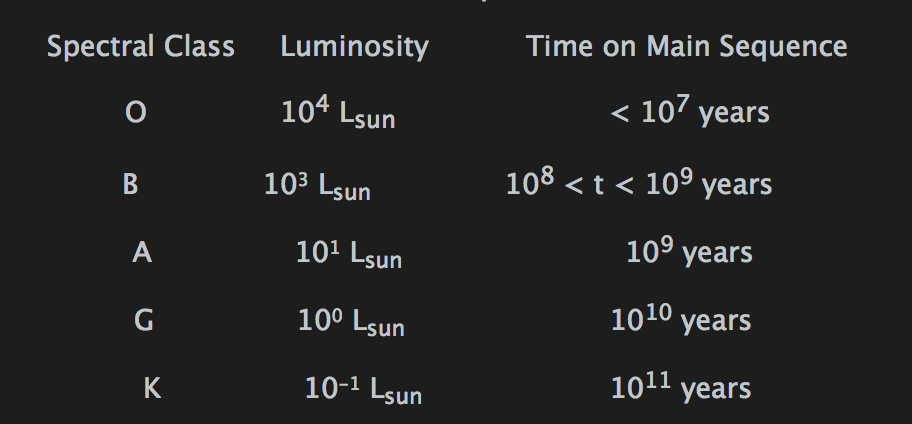

If the median lookback time is $1.3\times 10 ^8$ years, it's possible that passive stellar evolution plays a significant role for O and B type stars, but not for other spectral types since their turnoff ages are at least an order of magnitude higher than the lookback time.

* ii. Equation (2) provides an expression for the luminosity distance in terms of the deceleration parameter $q_0$. The parameter $q_0 = Ω_M/2$ and assumes that $Ω_Λ = 0$. How does the luminosity distance expression given in Lin et al. compare to the value returned by your cosmological model? Express your answer in terms of the distance modulus.

Okay, so what value do we get using Lin's expression? For WMAP7, $\Omega_M=0.272$, so $q_0 = 0.136$.

Lin's expression is:

$d_L = \frac{c}{H_0q_0^2}\bigg[q_0z+(1-q_0)(1-\sqrt{1+2q_0z}\bigg]$.

I'll evaluate it now:

In [16]:
def lin_dl(c, H0, q0, z):
    dl = (c / (H0 * q0**2)) * (q0 * z + (1 - q0)*(1 - np.sqrt(1 + 2 * q0 *z)) )
    return(dl)

In [17]:
lum_dist_lin = lin_dl(2.998*10**5, cosmo.H0.value, 0.136, .1)  # assuming median redshift value
lum_dist_wmap7 = cosmo.luminosity_distance(z=0.1).value
print('Luminosity distance as given by Lin: {} Mpc'.format(lum_dist_lin))
print('Luminosity distance as given by WMAP7 cosmology: {} Mpc'.format(lum_dist_wmap7))

Luminosity distance as given by Lin: 444.00306816001176 Mpc
Luminosity distance as given by WMAP7 cosmology: 458.64149272470024 Mpc


Now let's get the distance modulus: $M - m = -25 -5 \log{(d_L)} - k(z)$

What should we use for the k-correction? According to Lin, we can take it to be $k(z) = 2.5\log{(1+z)}$ for LCRS.

In [18]:
def get_dist_mod(dl, z):
    dist_mod = -25 - 5 * np.log10(dl) - 2.5 * np.log10(1 + z)
    return dist_mod

In [19]:
dist_mod_Lin = get_dist_mod(lum_dist_lin, 0.1)
dist_mod_wmap7 = get_dist_mod(lum_dist_wmap7, 0.1)

print('Distance modulus as given by Lin: {} Mpc'.format(dist_mod_Lin))
print('Distance modulus as given by WMAP7 cosmology: {} Mpc'.format(dist_mod_wmap7))

Distance modulus as given by Lin: -38.34041156887811 Mpc
Distance modulus as given by WMAP7 cosmology: -38.41084842415677 Mpc


Pretty close!

* iii. Equation (3) assumes that the k–correction is dominated by the bandwidth term and not by any spectral variation. Test this assumption by computing the full k– correction term at a redshift z = 0.1 for two template spectra representing a typical early–type (ell) and late–type (scd) galaxies. Are the results significantly different than the result obtained using the bandwidth term alone?

In [112]:
## come back to this

* Compute the absolute r–band magnitude for each galaxy in the sample. For simplicity, you may assume that Equations (1–3) of Lin et al. are good approximations. Note that the apparent magnitude limits for each galaxy vary as a function of survey field (there are 289 survey fields). It will speed things up later on if you compute the absolute magnitude limits (from the apparent magnitude limits for the field) for each galaxy at this stage as well. Note that you should be working with isophotal, not central, magnitudes. Plot the variation of absolute isophotal magnitude versus redshift for a representative 112 and 50 fibre field. Plot the effective absolute magnitude limits as a function of redshift of the field on each plot as well.

To calculate the absolute magnitude, we can use the distance modulus equation. I'll do that first:

In [21]:
def get_abs_mag(galaxy):

    z = galaxy['REDSHIFT']
    m = galaxy['ISOPHOTAL_MAG']
    M = m - 25 - 5 * np.log(cosmo.luminosity_distance(z=z).value) - 2.5* np.log(1 + z)
   
    return M

In [22]:
abs_mag_col = []  # to store absolute magnitudes

for i in range(0, len(catalog)):  # loop through each galaxy
    galaxy = catalog[i]
    abs_mag = get_abs_mag(galaxy)
    abs_mag_col.append(abs_mag)
    
abs_mag_col = Column(abs_mag_col, name='ABSOLUTE_MAG')
catalog.add_column(abs_mag_col)


# make a column for absolute magnitude
#new_col = Column(catalog["ISOPHOTAL_MAG"] - 25 - 5 * np.log10(cosmo.luminosity_distance(z=catalog['REDSHIFT'].data)) - k(catalog['REDSHIFT']), name='ABSOLUTE_MAG')
#catalog.add_column(new_col)

In [23]:
catalog

FIELD_NAME,NAME,ISOPHOTAL_MAG,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,CLASS,REDSHIFT,ABSOLUTE_MAG
str10,str21,float64,int32,int32,str7,float64,float64
0015-42M,LCRS B002517.7-421621,17.48,45629,56,GALAXY,0.152198132088,-40.7897452491
2255-42M,LCRS B231051.9-421601,16.12,1679,33,GALAXY,0.00560040026684,-24.7748357254
0400-42W,LCRS B040221.3-420748,17.36,63898,73,GALAXY,0.213135423616,-42.9107521032
2215-42W,LCRS B222214.5-421454,17.0,16210,56,GALAXY,0.0540693795864,-35.5345414756
2135-42W,LCRS B214037.7-421325,16.21,21454,40,GALAXY,0.0715610406938,-37.8307716168
0054-42M,LCRS B010511.2-421539,17.74,53196,56,GALAXY,0.177438292195,-41.431026264
0134-42W,LCRS B014055.9-421443,16.6,28587,47,GALAXY,0.095353569046,-39.0150316269
0015-42W,LCRS B002338.6-421614,17.24,45735,57,GALAXY,0.152551701134,-41.043252391
0415-42W,LCRS B041730.1-420647,17.12,15876,38,GALAXY,0.0529553035357,-35.3036903228


In [25]:
# first step is to get all of the field-names
field_names = unique(catalog, keys='FIELD_NAME')
field_names = field_names['FIELD_NAME'].data

In [41]:
# take a look
catalog

FIELD_NAME,NAME,ISOPHOTAL_MAG,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,CLASS,REDSHIFT,ABSOLUTE_MAG,FIELD_ABS_MAX,FIELD_ABS_MIN
str10,str21,float64,int32,int32,str7,float64,float64,int64,int64
0015-42M,LCRS B002517.7-421621,17.48,45629,56,GALAXY,0.152198132088,-40.7897452491,-40,-43
2255-42M,LCRS B231051.9-421601,16.12,1679,33,GALAXY,0.00560040026684,-24.7748357254,-23,-25
0400-42W,LCRS B040221.3-420748,17.36,63898,73,GALAXY,0.213135423616,-42.9107521032,-42,-45
2215-42W,LCRS B222214.5-421454,17.0,16210,56,GALAXY,0.0540693795864,-35.5345414756,-34,-37
2135-42W,LCRS B214037.7-421325,16.21,21454,40,GALAXY,0.0715610406938,-37.8307716168,-36,-38
0054-42M,LCRS B010511.2-421539,17.74,53196,56,GALAXY,0.177438292195,-41.431026264,-41,-44
0134-42W,LCRS B014055.9-421443,16.6,28587,47,GALAXY,0.095353569046,-39.0150316269,-37,-40
0015-42W,LCRS B002338.6-421614,17.24,45735,57,GALAXY,0.152551701134,-41.043252391,-40,-43
0415-42W,LCRS B041730.1-420647,17.12,15876,38,GALAXY,0.0529553035357,-35.3036903228,-34,-37


In [27]:
# first, find two fields, one with ~50 galaxies in it, one with ~112
small = False
big = False

for field in field_names:
    if small==True and big==True:
        break
        
    # find all of the row with this field name
    gals_in_field = catalog[np.where(catalog['FIELD_NAME']==field)]
    num_gals = len(gals_in_field['FIELD_NAME'].data)
    
    if 48 < num_gals < 52:
        print('Field {} has {} galaxies in it'.format(field, num_gals))
        field1 = gals_in_field
        small = True
        app_mags = gals_in_field['ISOPHOTAL_MAG'].data
        # find the max and min
        m_max1 = np.amax(app_mags)
        m_min1 = np.amin(app_mags)
      

    if 109 < num_gals < 115:
        print('\nField {} has {} galaxies in it'.format(field, num_gals))
        field2 = gals_in_field
        big = True
        app_mags = gals_in_field['ISOPHOTAL_MAG'].data
        # find the max and min
        m_max2 = np.amax(app_mags)
        m_min2 = np.amin(app_mags)
      

Field 0040-42E   has 50 galaxies in it

Field 0134-42M   has 110 galaxies in it


In [28]:
field1_name = field1['FIELD_NAME'][0]
field2_name = field2['FIELD_NAME'][0]

In [29]:
def get_abs_mag_limit(galaxy, gals_in_field,
                      m_min, m_max, 
                      field, count, 
                      redshift_list50, redshift_list110,
                      M_max_list50, M_min_list50,
                      M_max_list110, M_min_list110):

    # from the Lin paper
    z = galaxy['REDSHIFT']
    M_min = m_min - 25 - 5 * np.log(cosmo.luminosity_distance(z=z).value) - k(z)
    M_max = m_max - 25 - 5 * np.log(cosmo.luminosity_distance(z=z).value) - k(z)

    # add these values to the correct lists
    if count == 0:
        M_min_list50.append(M_min)
        M_max_list50.append(M_max)
        redshift_list50.append(z)
    else:
        M_min_list110.append(M_min)
        M_max_list110.append(M_max)
        redshift_list110.append(z)

In [30]:
# loop through each galaxy in order
galaxies = catalog['NAME']
field_names = [field1_name, field2_name]
mins = [m_min1, m_min2]
maxes = [m_max1, m_max2]
counts = [0,1]

# make some lists to store this data in
redshift_list50 = []
redshift_list110 = []
M_min_list50 = []
M_max_list50 = []
M_min_list110 = []
M_max_list110 = []


# loop through fields
for count in counts:
        # loop through all galaxies in the field
        gals_in_field = catalog[np.where(catalog['FIELD_NAME']==field_names[count])]
        for galaxy in gals_in_field:
            abs_mag_limit = get_abs_mag_limit(galaxy, gals_in_field, 
                                              mins[count], maxes[count], 
                                              field_names[count], count,
                                              redshift_list50, redshift_list110,
                                              M_max_list50, M_min_list50,
                                              M_max_list110, M_min_list110)

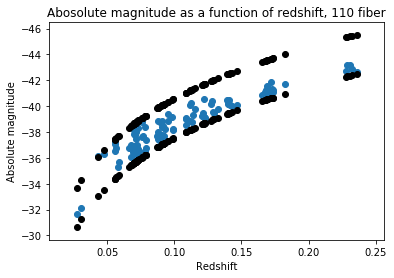

In [31]:
# absolue magnitude vs redshift 
plt.scatter(field2['REDSHIFT'].data, field2['ABSOLUTE_MAG'].data, label='110 galaxy field')

# add the magnitude limits
plt.scatter(redshift_list110, M_min_list110, color='k')
plt.scatter(redshift_list110, M_max_list110, color='k')

plt.gca().invert_yaxis()
plt.title('Abosolute magnitude as a function of redshift, 110 fiber')
plt.xlabel('Redshift')
plt.ylabel('Absolute magnitude')

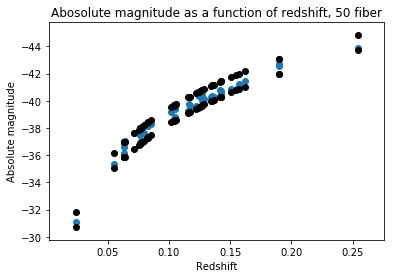

In [32]:
# absolue magnitude vs redshift
plt.scatter(field1['REDSHIFT'].data,field1['ABSOLUTE_MAG'].data)

# add the magnitude limits
plt.scatter(redshift_list50, M_min_list50, color='k')#, label='Abs. magnitude limit for 50 galaxy field')
plt.scatter(redshift_list50, M_max_list50, color='k')

plt.gca().invert_yaxis()
plt.title('Abosolute magnitude as a function of redshift, 50 fiber')
plt.xlabel('Redshift')
plt.ylabel('Absolute magnitude')

* Compute LF parameters for the LCRS sample employing the either the $1/V_{acc}$ or STY estimators. You may assume that the form of the LF is given by the Schechter function as detailed in Lin et al. Equation (8). Quote your answer in terms of a best–fitting characteristic magnitude, M∗, and faint–end slope, α. Also provide contours of relative likelihood in the M∗ versus α plane corresponding to a 2σ variation in the parameters.

I'll use the $1/V_{acc}$ method. The first step is to come up with a selction function $w(z)$. This means that for each galaxy in the dataset, I need to define a mask array showing which redshift range it can be in. The form of w(z) is given in the Lin paper.

In [33]:
# selection function, given by Lin
def w(mi, mk, delta_m):
    if mk - delta_m/2 <= mi and mi <= mk + delta_m/2:
        w = 1
    else:
        w = 0
    return w

No, actually, this doesn't seem to help; it doesn't give us a result as a function of z. I think I need to loop through each field andfit a function to the min and the max values.

In [34]:
def get_abs_mag_limit_mini(galaxy, gals_in_field,
                           m_min, m_max):

    # from the Lin paper
    z = galaxy['REDSHIFT']
    M_min = m_min - 25 - 5 * np.log(cosmo.luminosity_distance(z=z).value) - k(z)
    M_max = m_max - 25 - 5 * np.log(cosmo.luminosity_distance(z=z).value) - k(z)
    
    return(M_min, M_max)

In [68]:
# each galaxy will only be allowed in some given redshift range; find that range, and see if each galaxy is in it

# make a new column for abs_max and abs_min
catalog['FIELD_ABS_MAX']=9999.  # dummy value for now
catalog['FIELD_ABS_MIN']=9999.  # dummy value for now

# loop through fields
all_field_names = unique(catalog, keys='FIELD_NAME')
all_field_names = all_field_names['FIELD_NAME'].data
for field in all_field_names:
    
    # find all galaxies in this field
    gals_in_field = catalog[np.where(catalog['FIELD_NAME']==field)]
    # check if this is a 50 or 110 fiber galaxy; this determins m_min and m_max
    num_gals = len(gals_in_field['FIELD_NAME'].data)

    if num_gals > 50.:   # values from Lin
        m_min = 15.
        m_max = 17.7
    else:
        m_min = 16.
        m_max = 17.3
    
    # loop through all galaxies
    for galaxy in gals_in_field:
        
        # get absolute magnitude limits
        M_min, M_max = get_abs_mag_limit_mini(galaxy, gals_in_field, m_min, m_max)
        # add them to the catalog
        catalog['FIELD_ABS_MAX'][np.where(catalog['NAME']==galaxy['NAME'])] = M_max
        catalog['FIELD_ABS_MIN'][np.where(catalog['NAME']==galaxy['NAME'])] = M_min

In [69]:
catalog

FIELD_NAME,NAME,ISOPHOTAL_MAG,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,CLASS,REDSHIFT,ABSOLUTE_MAG,FIELD_ABS_MAX,FIELD_ABS_MIN,w,PHI
str10,str21,float64,int32,int32,str7,float64,float64,int64,int64,int64,int64
0015-42M,LCRS B002517.7-421621,17.48,45629,56,GALAXY,0.152198132088,-40.7897452491,-40,-43,1,0
2255-42M,LCRS B231051.9-421601,16.12,1679,33,GALAXY,0.00560040026684,-24.7748357254,-23,-25,1,0
0400-42W,LCRS B040221.3-420748,17.36,63898,73,GALAXY,0.213135423616,-42.9107521032,-42,-45,1,0
2215-42W,LCRS B222214.5-421454,17.0,16210,56,GALAXY,0.0540693795864,-35.5345414756,-34,-37,1,0
2135-42W,LCRS B214037.7-421325,16.21,21454,40,GALAXY,0.0715610406938,-37.8307716168,-36,-38,1,0
0054-42M,LCRS B010511.2-421539,17.74,53196,56,GALAXY,0.177438292195,-41.431026264,-41,-44,1,0
0134-42W,LCRS B014055.9-421443,16.6,28587,47,GALAXY,0.095353569046,-39.0150316269,-37,-40,1,0
0015-42W,LCRS B002338.6-421614,17.24,45735,57,GALAXY,0.152551701134,-41.043252391,-40,-43,1,0
0415-42W,LCRS B041730.1-420647,17.12,15876,38,GALAXY,0.0529553035357,-35.3036903228,-34,-37,1,0


Don't know why they are rounded to integers, but I will come back to that later. Now that I have all the absolute magnitude minimums and maximums, I can reject the galaxies which have an absolute magnitude outside of the limits corresponding to their redshift and filter. I'll make this a new column, with a flag of 0 or 1.

In [54]:
#catalog['FIELD_ABS_MAX'][np.where(catalog['NAME']==galaxy['NAME'])] = M_max

catalog['w'] = 0  # 0 -> reject, 1 -> accept

for galaxy in catalog:
    abs_mag = galaxy['ABSOLUTE_MAG']
    max_abs_mag = galaxy['FIELD_ABS_MAX']
    min_abs_mag = galaxy['FIELD_ABS_MIN']
    if abs_mag <= max_abs_mag and abs_mag >= min_abs_mag:
        galaxy['w'] = 1

In [55]:
catalog

FIELD_NAME,NAME,ISOPHOTAL_MAG,RADIAL_VELOCITY,RADIAL_VELOCITY_ERROR,CLASS,REDSHIFT,ABSOLUTE_MAG,FIELD_ABS_MAX,FIELD_ABS_MIN,w
str10,str21,float64,int32,int32,str7,float64,float64,int64,int64,int64
0015-42M,LCRS B002517.7-421621,17.48,45629,56,GALAXY,0.152198132088,-40.7897452491,-40,-43,1
2255-42M,LCRS B231051.9-421601,16.12,1679,33,GALAXY,0.00560040026684,-24.7748357254,-23,-25,1
0400-42W,LCRS B040221.3-420748,17.36,63898,73,GALAXY,0.213135423616,-42.9107521032,-42,-45,1
2215-42W,LCRS B222214.5-421454,17.0,16210,56,GALAXY,0.0540693795864,-35.5345414756,-34,-37,1
2135-42W,LCRS B214037.7-421325,16.21,21454,40,GALAXY,0.0715610406938,-37.8307716168,-36,-38,1
0054-42M,LCRS B010511.2-421539,17.74,53196,56,GALAXY,0.177438292195,-41.431026264,-41,-44,1
0134-42W,LCRS B014055.9-421443,16.6,28587,47,GALAXY,0.095353569046,-39.0150316269,-37,-40,1
0015-42W,LCRS B002338.6-421614,17.24,45735,57,GALAXY,0.152551701134,-41.043252391,-40,-43,1
0415-42W,LCRS B041730.1-420647,17.12,15876,38,GALAXY,0.0529553035357,-35.3036903228,-34,-37,1


Awesome. Now it's time to do an integral and find $V_{acc}$ for each galaxy:

$V_{acc, i} = \int^{0}_{\infty} \frac{dV_c}{dz}w_i(z)dz$.

This can be done for each galaxy individually, and then added all together as a weighted histogram because $\phi_i = 1/V_{acc, i}$.

In [61]:
catalog['PHI'] = 0.

In [97]:
phi_list = []
redshift_list = []
M_list = []

for galaxy in catalog:
    w = galaxy['w']
    if w == 1:  # ignore this galacxy if w=0
        v_acc = cosmo.differential_comoving_volume(z = galaxy['REDSHIFT'])
        phi = 1/v_acc
        # having problems with the table, so I will just make some lists for the plot
        phi_list.append(phi.value)
        redshift_list.append(galaxy['REDSHIFT'])
        M_list.append(galaxy['ABSOLUTE_MAG'])

In [111]:
# go through bins of M
binsize = 1 # mags
start = -50 # mags
stop = 0

num_bins = abs(stop - start + binsize) / binsize
i_per_bin = []

for M in range(start, stop+binsize, binsize):
    phi_i = phi_list[np.where(abs(np.asarray(M_list)-M)<binsize)]
    i_per_bin.append(phi_i)

TypeError: list indices must be integers or slices, not tuple

101.0


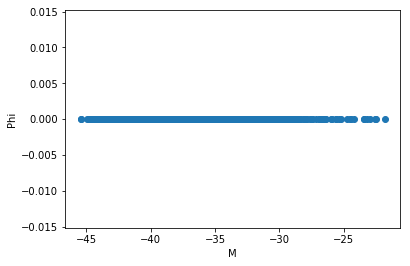

In [106]:
plt.scatter(M_list, phi_list)
plt.ylabel('Phi')
plt.xlabel('M')

I know what this plot should look like, but I'm not sure how to code it! It should have $M$ on the x-axis and $\phi$ on the y-axis. Each small $\phi_i$ contribution should be binned into some range of $M$ and then theu should be stacked on top of each other like a weighted histogram. A schecter function could then be fit on top, and parameters could be found using 2D contours and $\chi^2$ minimization.